In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 10.0)
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
from PIL import Image
from scipy.signal import convolve2d
from skimage.measure import block_reduce, find_contours
from matplotlib.patches import Rectangle
from kural_core.models import *
from kural_core.data_processing import *
from kural_core.functions import *
from kural_core.train_model import train_model
import pickle
from scipy.misc import imresize
from scipy.ndimage import morphology
from scipy.spatial import ConvexHull
from skimage import measure
from matplotlib import animation, rc
from IPython.display import HTML, display, clear_output
from os import listdir
from nd2reader import ND2Reader
from ipywidgets import widgets, Layout

PATH = r'D:\Code\kural_work\actin_gan_data\\'

In [ ]:
with open(PATH+'he_le_tuple.pickle','rb') as f:
    he, le = pickle.load(f)

In [7]:
ds = ActinGanDataset(he, le)

In [4]:
with open(PATH+'good_high_and_low.pickle','rb') as f:
    good = pickle.load(f)
is_good = []
for i in range(good[0].shape[0]):
    is_good.append((good[0][i][None],good[1][i][None]))

In [35]:
def display_imgs():
    clear_output(wait=True)
    fig, ax = plt.subplots(1,2,figsize=(16,14))
    chance = 0
    while chance<0.5:
        idx = np.random.choice(len(ds))
        h,l = ds[idx]
        chance = nn.Softmax(1)(classifier_model((h.cuda()-mini)/(maxi-mini))).data.cpu().numpy()[0,1]
    m = ax[0].imshow(h[0,0])
    plt.colorbar(mappable=m, ax=ax[0],shrink=0.4)
    m = ax[1].imshow(l[0,0])
    plt.colorbar(mappable=m, ax=ax[1],shrink=0.4)
    plt.show()
    fig.subplots_adjust(wspace=0.01, hspace=0)
    
    def yes(btn):
        is_good.append((h.clone().detach().data,l.clone().detach().data))
        print('Was good!')
        display_imgs()
    def no(btn):
        print('Was not good!')
        display_imgs()
    y = widgets.Button(description='Yes, good')
    y.on_click(yes)
    n = widgets.Button(description='No, not good')
    n.on_click(no)
    w = widgets.HBox([y, n])
    display(w)

In [11]:
auto_good = []
i = 0
while len(auto_good)<10000:
    chance = 0
    while chance<0.5:
        idx = np.random.choice(len(ds))
        h,l = ds[idx]
        h = (h-h.mean())/h.std()
        l = (l-l.mean())/l.std()
        chance = nn.Softmax(1)(classifier_model(h.cuda())).data.cpu().numpy()[0,1]
        i+=1
#         print(chance)
    auto_good.append((h.clone().detach().data,l.clone().detach().data))
    if len(auto_good)%999==0:
        print(len(auto_good))

507 0.1952662721893491
1010 0.19603960396039605
1470 0.20204081632653062
1890 0.20952380952380953
2431 0.20361990950226244
2932 0.20259208731241474
3527 0.1964842642472356
4113 0.1925601750547046
4560 0.19539473684210526
4976 0.1989549839228296
5474 0.1989404457435148
6014 0.1975390754905221
6551 0.19645855594565714
7001 0.19797171832595342
7468 0.1988484199250134
7965 0.19887005649717515
8468 0.19874822862541333
8953 0.19903942812465095
9422 0.19963914243260455
9911 0.1997780244173141
10348 0.20090838809431774
10859 0.20057095496822913
11436 0.1991080797481637
11958 0.19869543401906672
12520 0.19768370607028754
13122 0.19615912208504802
13601 0.19652966693625468
14120 0.1963172804532578
14631 0.1962271888456018
15113 0.19651955270297095
15545 0.19742682534577036
15951 0.19860823772804212
16469 0.19837270022466452
17015 0.1978254481339994
17481 0.19821520507980092
18047 0.19748434642876933
18537 0.19760479041916168
19110 0.19686028257456828
19660 0.1963886063072228
20160 0.196428571428

In [12]:
len(auto_good)

10000

In [13]:
auto_good[0]

(tensor([[[[ 0.2613,  0.0746, -0.2522,  ..., -0.6957, -0.7424, -0.9291],
           [ 1.1949,  0.6348,  0.5647,  ..., -0.9758, -0.9058, -0.5790],
           [ 1.9185,  1.4284,  0.9849,  ..., -0.9991, -0.9058, -0.8591],
           ...,
           [ 0.2380, -0.0188, -0.2289,  ..., -1.0225, -1.0458, -1.0225],
           [ 0.5881, -0.6257, -0.1355,  ..., -0.8357, -0.8124, -0.6724],
           [-0.1122, -0.1355, -0.4156,  ..., -0.9524, -0.9058, -0.9291]]]]),
 tensor([[[[ 0.2595, -0.6774, -1.1459,  ...,  0.4938, -1.8486, -1.1459],
           [-0.2089,  1.4307, -0.2089,  ..., -0.6774, -0.4432,  0.4938],
           [ 0.0253,  0.7280,  0.4938,  ...,  0.0253, -0.9116, -0.6774],
           ...,
           [-1.1459, -0.2089, -1.1459,  ..., -1.1459,  0.4938, -2.5513],
           [ 0.2595,  0.4938, -0.9116,  ..., -0.6774,  0.4938, -0.9116],
           [-0.4432, -0.6774,  0.0253,  ...,  0.0253, -0.2089,  0.0253]]]]))

In [31]:
a = list('abdef')
print(a[::2])

['a', 'd', 'f']


KeyboardInterrupt: 

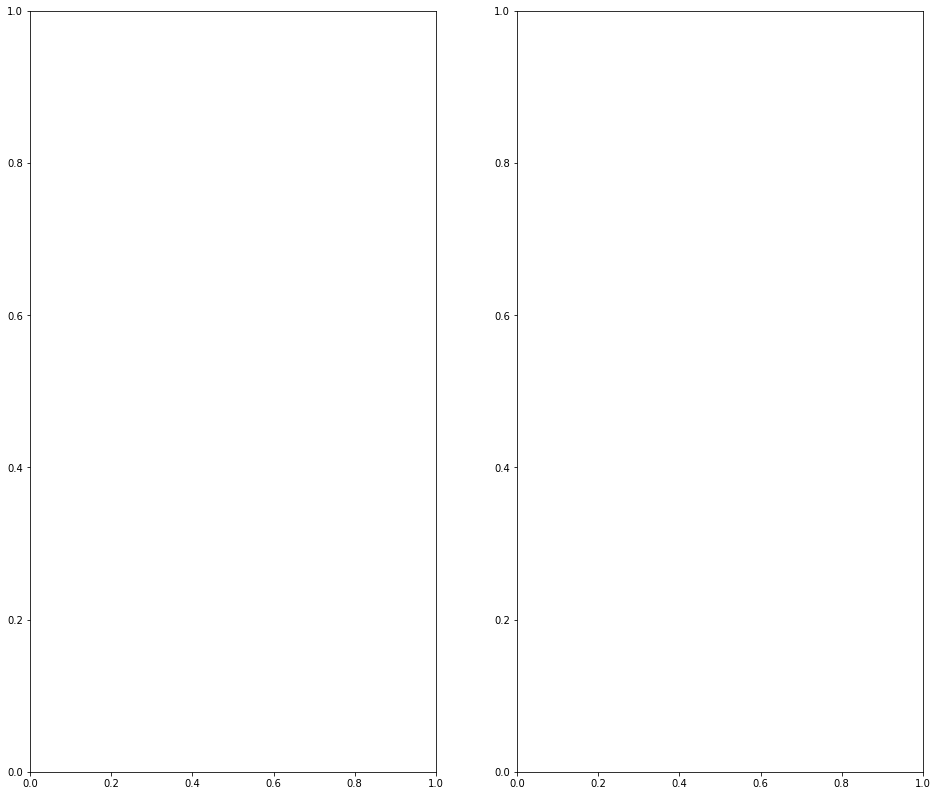

In [36]:
display_imgs()

In [32]:
good = (torch.cat([i for i,_ in is_good]),torch.cat([j for _,j in is_good]))
print(good[0].shape[0])
with open(PATH+'good_high_and_low.pickle','wb') as f:
    pickle.dump(good,f,protocol=4)

365


In [14]:
good = (torch.cat([i for i,_ in auto_good]),torch.cat([j for _,j in auto_good]))
print(good[0].shape[0])
with open(PATH+'good_high_and_low.pickle','wb') as f:
    pickle.dump(good,f,protocol=4)

10000


In [32]:
idx = np.random.choice(len(ds))
h,l = ds[idx]
print(h.shape)

torch.Size([1, 1, 128, 128])


In [2]:
classifier_model = ActinClassifierModel().cuda()

In [3]:
classifier_model.load_state_dict(torch.load(r'D:\Code\kural_work\actin_classifier_model.pth'))

In [4]:
for p in classifier_model.parameters():
    p.require_grad=False

In [5]:
classifier_model.eval()

ActinClassifierModel(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace)
    (3): Sequential(
      (0): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace)
    )
    (4): res_block(
      (conv): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.01, inplace)
 

In [61]:
nn.Softmax(1)(classifier_model((h.cuda()-mini)/(maxi-mini))).data.cpu().numpy()[0,1]

0.13346842

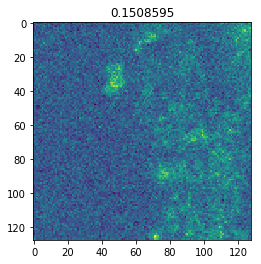

In [84]:
idx = np.random.choice(len(ds))
h,l = ds[idx]
chance = nn.Softmax(1)(classifier_model((h.cuda()-mini)/(maxi-mini))).data.cpu().numpy()[0,1]
plt.imshow(h[0,0])
plt.title(chance)
plt.show()

In [42]:
shuff_tmp = nn.PixelShuffle(2)(tmp);shuff_tmp

tensor([[[[ 0, 16,  1, 17,  2, 18,  3, 19],
          [32, 48, 33, 49, 34, 50, 35, 51],
          [ 4, 20,  5, 21,  6, 22,  7, 23],
          [36, 52, 37, 53, 38, 54, 39, 55],
          [ 8, 24,  9, 25, 10, 26, 11, 27],
          [40, 56, 41, 57, 42, 58, 43, 59],
          [12, 28, 13, 29, 14, 30, 15, 31],
          [44, 60, 45, 61, 46, 62, 47, 63]]]], dtype=torch.int32)

In [43]:
shuff_tmp.shape

torch.Size([1, 1, 8, 8])

In [51]:
test = good[0][0:1]

In [53]:
test_model = ActinUNetModel()

In [2]:
with open(PATH+'good_high_and_low.pickle','rb') as f:
    good = pickle.load(f)

In [37]:
with open(PATH+'actin_classifier_model_image_normalization.pickle','rb') as f:
    mini, maxi = pickle.load(f)

In [3]:
good = list(good)

In [4]:
for i in range(2):
    for j in range(good[i].shape[0]):
        good[i][j] = (good[i][j]-good[i][j].mean())/good[i][j].std()

In [8]:
ds = ActinUNetDataset(good)
train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, K=5, rand_seed=42, nORp=1)
bs = 10
clip = 50
train_dl = torch.utils.data.DataLoader(ds, batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True))
val_dl = torch.utils.data.DataLoader(ds, batch_size=bs, sampler=SubsetSampler(val_idx))
model = ActinUNetModel().cuda()
opt = torch.optim.Adam(model.parameters())
train_loss = []
val_loss = []
criterion = ActinUNetPerceptualLoss(classifier_model)
# criterion = nn.L1Loss()
# criterion = ActinProbabalisticLoss()

In [9]:
model, _tl, _vl = train_model(model, train_dl, val_dl, opt, criterion, lr_start=1e-3, lr_end=1, epochs=100, cycles=1, lr_cycle='sin')
train_loss += _tl
val_loss += _vl
torch.save(model.state_dict(),r'D:\Code\kural_work\actin_snr_boost.pth')
model, _tl, _vl = train_model(model, train_dl, val_dl, opt, criterion, lr_start=1e-3, lr_end=1e-6, epochs=10, cycles=1, lr_cycle='cos')
train_loss += _tl
val_loss += _vl
torch.save(model.state_dict(),r'D:\Code\kural_work\actin_snr_boost.pth')

><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><
Spent 45m 58s doing 10 total steps for an average of 275.8s per step.
><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><


In [80]:
torch.save(model.state_dict(),r'D:\Code\kural_work\actin_snr_boost.pth')

In [4]:
model = ActinUNetModel().cuda()
model.load_state_dict(torch.load(r'D:\Code\kural_work\actin_snr_boost.pth'))
for p in model.parameters():
    p.requires_grad = False
ds = ActinUNetDataset(good)

In [69]:
train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, K=5, rand_seed=42, nORp=1)

In [25]:
lr_range = [1e-6*(10**(i/5)) for i in range(30)]
for lr in lr_range:
    model, _tl, _vl = train_model(model, train_dl, val_dl, opt, criterion, lr_start=lr, lr_end=None, epochs=1, cycles=1)
    train_loss += _tl
    val_loss += _vl
    if _tl[0]>100: break

><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><
Spent 0m  6s doing 1 total steps for an average of 6.1s per step.
><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><


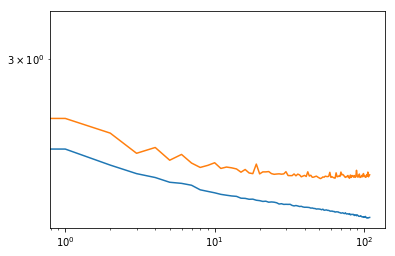

In [10]:
x = list(range(len(train_loss)))
# x = lr_range
slc = slice(0,len(train_loss))
plt.plot(x[slc],train_loss[slc])
plt.plot(x[slc],val_loss[slc])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [17]:
x_test.shape

torch.Size([1, 128, 128])

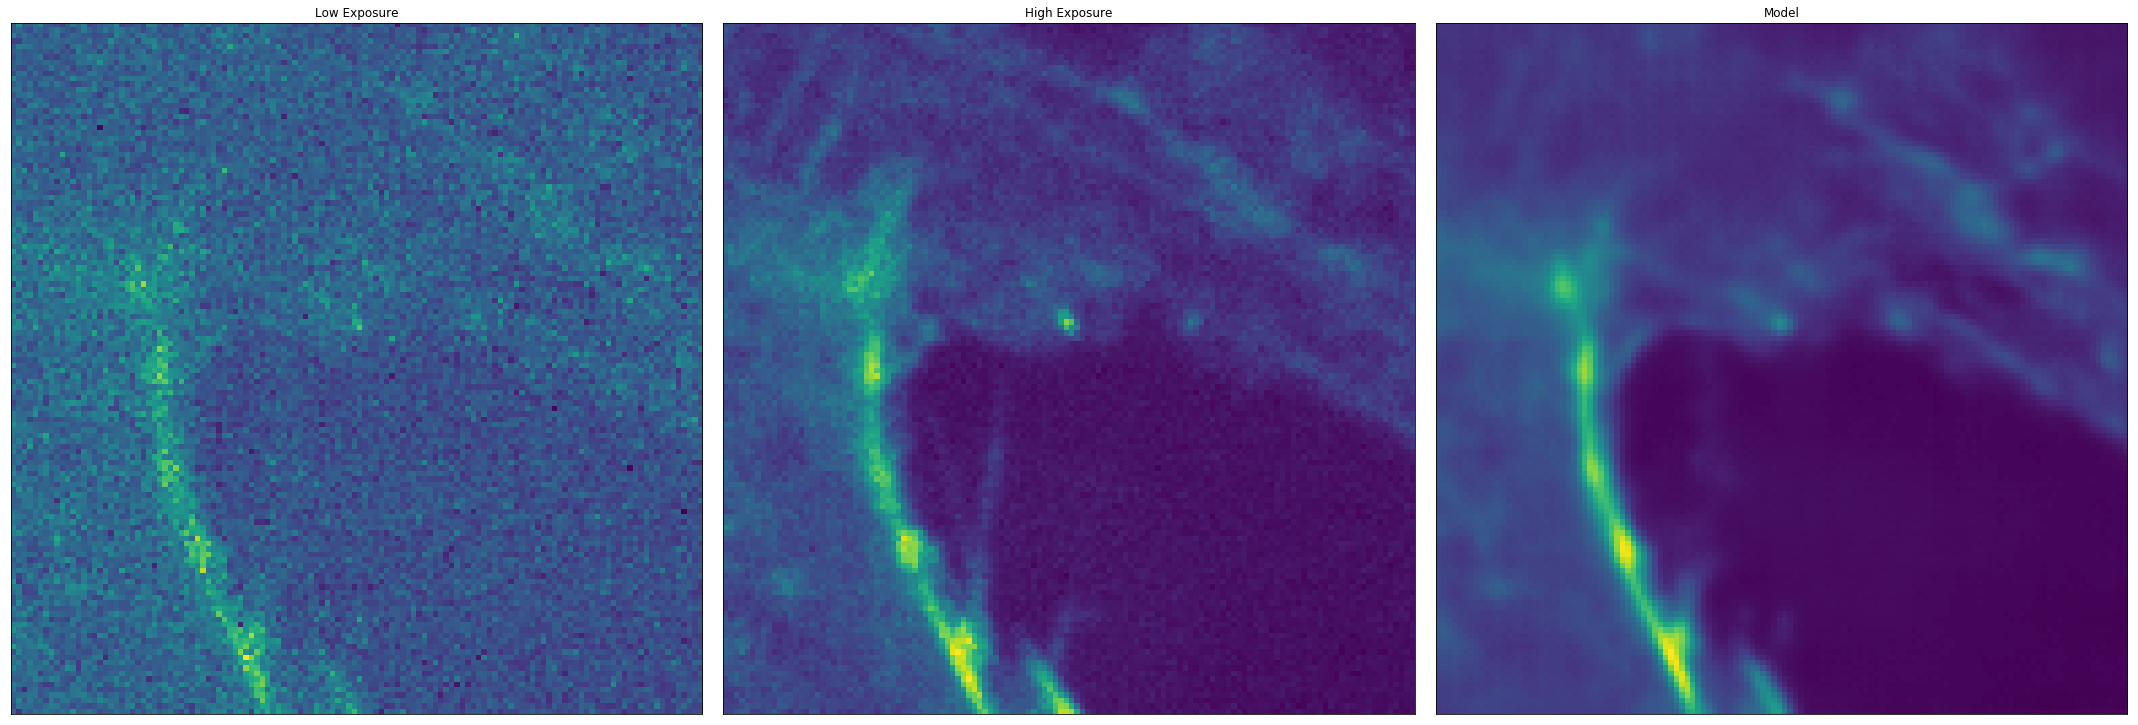

In [95]:
fig, ax = plt.subplots(1,3,figsize=(30,10))
model.train()
idx = np.random.choice(train_idx)
x_test, y_test = ds[idx]
m = ax[0].imshow(x_test[0])
# plt.colorbar(mappable=m, ax=ax[0], shrink=0.5)
ax[0].set_title('Low Exposure')
m = ax[1].imshow(y_test[0])
# plt.colorbar(mappable=m, ax=ax[1], shrink=0.5)
ax[1].set_title('High Exposure')
y_pred = model(x_test[None].cuda())
img_out = y_pred[0][0,0].data.cpu()
m = ax[2].imshow(img_out)
# plt.colorbar(mappable=m, ax=ax[2], shrink=0.5)
ax[2].set_title('Model')
for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.subplots_adjust(left=0.01, bottom=0, right=.99, top=.98, wspace=0.03, hspace=0)
plt.savefig(PATH+'model_output.png')

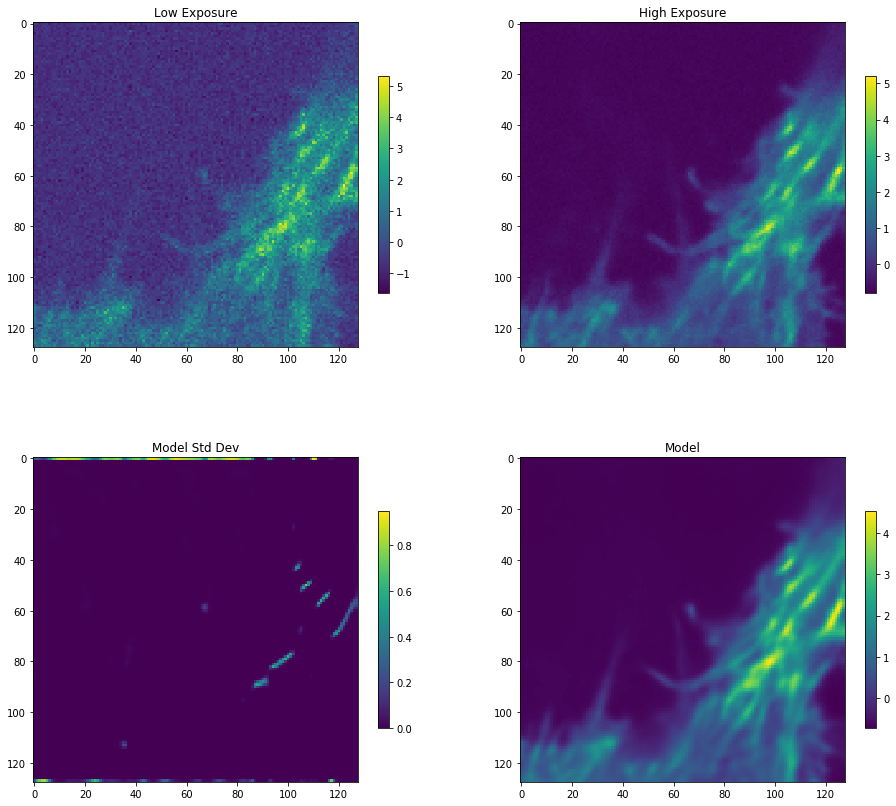

In [28]:
fig, ax = plt.subplots(2,2,figsize=(16,16))
model.eval()
idx = np.random.choice(len(ds))
x_test, y_test = ds[idx]
m = ax[0, 0].imshow(x_test[0])
plt.colorbar(mappable=m, ax=ax[0, 0], shrink=0.5)
ax[0, 0].set_title('Low Exposure')
m = ax[0, 1].imshow(y_test[0])
plt.colorbar(mappable=m, ax=ax[0, 1], shrink=0.5)
ax[0, 1].set_title('High Exposure')
y_pred = model(x_test[None].cuda())
img_out = y_pred[0][0,0].data.cpu()
std_out = nn.Softmax(0)(y_pred[1][0,0]).view(128,128).data.cpu()
m = ax[1, 1].imshow(img_out)
plt.colorbar(mappable=m, ax=ax[1, 1], shrink=0.5)
ax[1, 1].set_title('Model')
m = ax[1, 0].imshow(std_out)
plt.colorbar(mappable=m, ax=ax[1, 0], shrink=0.5)
ax[1, 0].set_title('Model Std Dev')
fig.subplots_adjust(hspace=0.0)
plt.show()

In [59]:
img_file = ND2Reader(PATH+'NDSequence001.nd2')
test_img = img_file.get_frame_2D(c=0,v=0)
test_img = torch.tensor(np.float32(test_img))[None, None].cuda()
# test_img = (test_img-test_img.mean())/test_img.std()

In [63]:
ref_img = nn.ReflectionPad2d(64)(test_img)
ref_img.requires_grad = False
mean_img = nn.functional.conv2d(ref_img, torch.ones((1,1,128,128), requires_grad=False).cuda()/128/128)[:,:,:1200,:1200]
sq_mean_img = nn.functional.conv2d(ref_img**2, torch.ones((1,1,128,128), requires_grad=False).cuda()/128/128)[:,:,:1200,:1200]
std_img = torch.sqrt(sq_mean_img-mean_img**2)
norm_img = (test_img-mean_img)/std_img

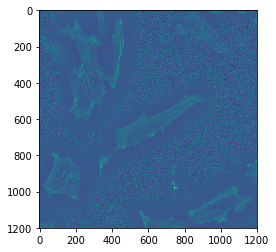

In [65]:
plt.imshow(norm_img[0,0].data.cpu())

In [66]:
out = model(norm_img.cpu())

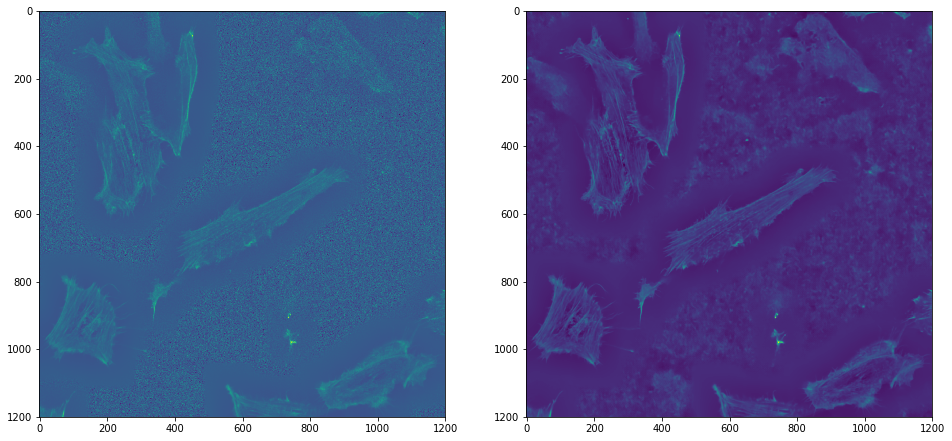

In [68]:
_, ax = plt.subplots(1,2,figsize=(16,10))
ax[0].imshow(norm_img[0,0].data.cpu())
ax[1].imshow(out[0][0,0].data)

In [69]:
img_file = ND2Reader(PATH+'NDSequence001.nd2')
low_img = img_file.get_frame_2D(c=0,v=0)
high_img = img_file.get_frame_2D(c=1,v=0)

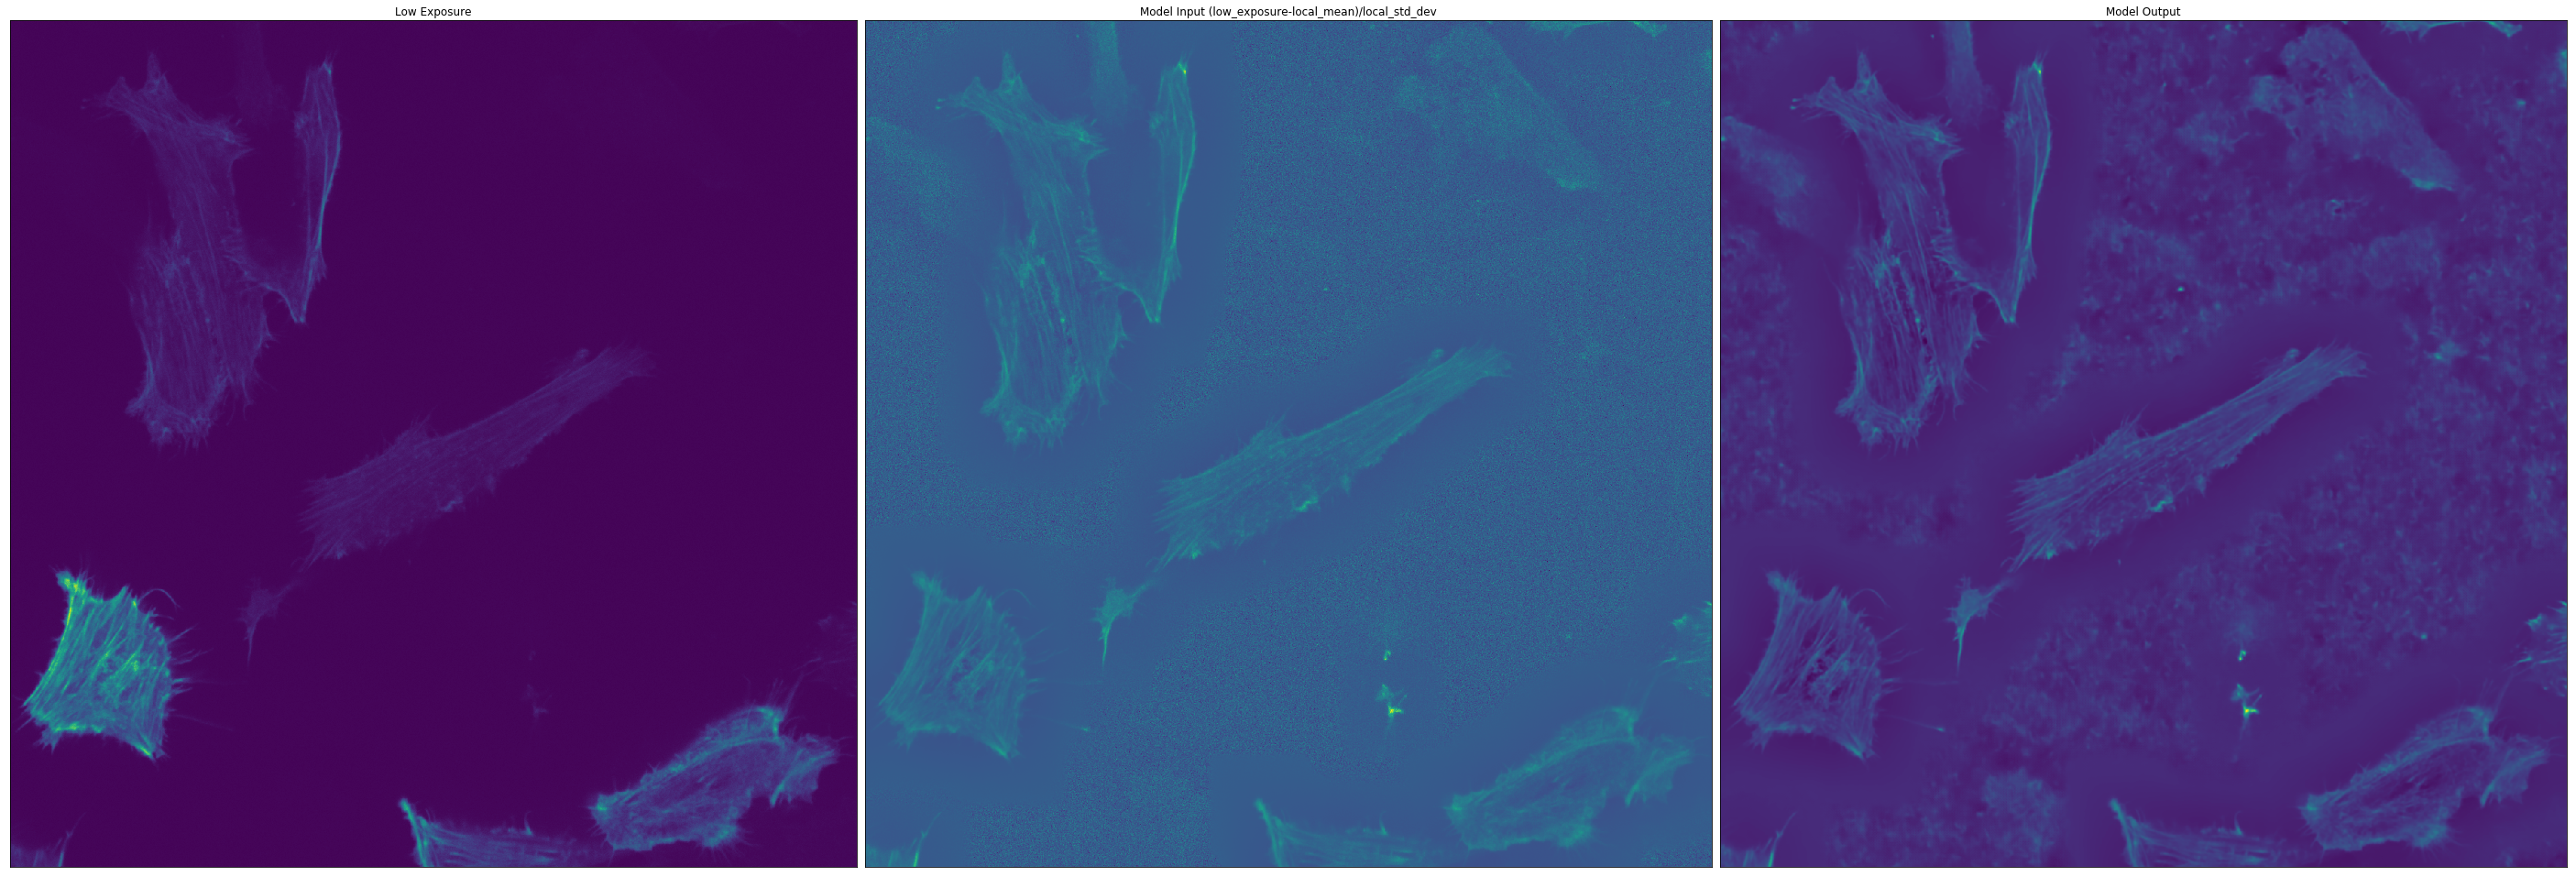

In [82]:
fig, ax = plt.subplots(1,3,figsize=(50,20))
ax[0].imshow(low_img)
ax[0].set_title("Low Exposure")
ax[1].imshow(norm_img[0,0].data.cpu())
ax[1].set_title("Model Input (low_exposure-local_mean)/local_std_dev")
ax[2].imshow(out[0][0,0].data)
ax[2].set_title("Model Output")
for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.subplots_adjust(wspace=0.01)
plt.savefig(PATH+'tmp.png')

In [62]:
i=0
for j, m in enumerate(model.modules()):
    if not (isinstance(m,nn.Conv2d) or isinstance(m,nn.BatchNorm2d) or isinstance(m, nn.LeakyReLU)): continue
    if i == 0:
        out = m(x_test[None].cuda())
    else:
        out = m(out)
    i+=1
    if j==24: break

In [63]:
out.shape

torch.Size([1, 32, 64, 64])

In [74]:
aloss = ActinUNetPerceptualLoss(classifier_model)

In [102]:
aloss(model(x_test[None].cuda()),y_test[None].cuda()).cpu()

predicted shape is torch.Size([1, 1, 128, 128])
actual shape is torch.Size([1, 1, 128, 128])
predicted shape is torch.Size([1, 8, 128, 128])
actual shape is torch.Size([1, 8, 128, 128])
predicted shape is torch.Size([1, 16, 64, 64])
actual shape is torch.Size([1, 16, 64, 64])
predicted shape is torch.Size([1, 32, 32, 32])
actual shape is torch.Size([1, 32, 32, 32])


tensor(6.7990, grad_fn=<CopyBackwards>)

In [79]:
lm = list(iter(classifier_model.modules()))

In [80]:
lm[2]

Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))